In [1]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 

from glob import glob
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'Available GPU number: {len(physical_devices)}')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

CLASS_SIZE = 10
TRAINING_EPOCHS = 50
BATCH_SIZE = 32

Available GPU number: 1


In [3]:
path_to_dataset = r'.\Sentinel Sat data'
path_to_training_dataset = os.path.join(path_to_dataset, 'Train') 
path_to_test_dataset = os.path.join(path_to_dataset, 'Test')            #Test how trained model performs on unfamilier data
path_to_validation_dataset = os.path.join(path_to_dataset, 'Validation')    #Validate model

<h4>Transforming 64x64 images into numpy array using <i>OpenCV2</i></h4>

In [4]:
%%time
def transformToDataFrame(path):
    sub_dir_list = os.listdir(path)
    classes_path = []
    for sub_dir in sub_dir_list:
        classes_path.append(os.path.join(path, sub_dir))

    images_glob = []
    for class_path in classes_path:
        images = glob(class_path + r'\*.*')
        images_glob.append(images)

    label_num = 1
    images_list = []
    labels_list = []
    for images in images_glob:
        for image in tqdm(images):
            img = cv2.imread(image)
            img = cv2.cvtColor(img, code=cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))
            images_list.append(img)
            labels_list.append(label_num)
        label_num += 1
    
    dataframe = pd.DataFrame()
    dataframe['image'] = images_list
    dataframe['label'] = labels_list
    
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    return dataframe

def reshapeTensors(array_to_reshape, length):
    tensor = []
    for i in tqdm(range(length)):
        element = np.array(array_to_reshape[i].reshape(64, 64, 3))
        tensor.append(element)
    tensor = np.array(tensor)
    return tensor

dataframe_training = transformToDataFrame(path_to_training_dataset)
dataframe_validation = transformToDataFrame(path_to_validation_dataset)

X_train, y_train = np.array(dataframe_training['image']), np.array(dataframe_training['label'])
X_val, y_val = np.array(dataframe_validation['image']), np.array(dataframe_validation['label'])

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

def reshapeTensors(array_to_reshape, length):
    tensor = []
    for i in tqdm(range(length)):
        element = np.array(array_to_reshape[i].reshape(64, 64, 3))
        tensor.append(element)
    tensor = np.array(tensor)
    return tensor

X_train = reshapeTensors(X_train, X_train.shape[0]) / 255
X_val = reshapeTensors(X_val, X_val.shape[0]) / 255

100%|██████████| 5400/5400 [00:00<00:00, 11249.85it/s]


Wall time: 4min 34s


<h4>Transforming 64x64 images into trainable data using Tensorflow Keras <i>flow_from_directory()</i></h4>

In [5]:
%%time

training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, 
                                                                             horizontal_flip=True, 
                                                                                 vertical_flip=True)

validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                               horizontal_flip=True,
                                                                                   vertical_flip=True)

training_dataset_flow = training_data_generator.flow_from_directory(path_to_training_dataset, 
                                                                  target_size=(64, 64),
                                                                      batch_size=BATCH_SIZE,
                                                                          class_mode='categorical')

validation_dataset_flow = validation_data_generator.flow_from_directory(path_to_validation_dataset,
                                                                      target_size=(64, 64),
                                                                          batch_size=BATCH_SIZE, 
                                                                              class_mode='categorical')

Found 18900 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Wall time: 30.4 s


<h4>ResNet50V2 model creation function</h4>

In [6]:
def createModel(class_num:int=10, input_shape:tuple=(64, 64, 3), activation_function:str='softmax', trainable:str=False):
    model_ResNet = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    output_layer = model_ResNet.layers[-1].output
    output_layer = GlobalAveragePooling2D()(output_layer)
    output_layer = Flatten()(output_layer)
    output_layer = Dropout(0.3)(output_layer)

    model_ResNet = Model(inputs=model_ResNet.input, outputs=output_layer)
    
    for layer in model_ResNet.layers:
        layer.trainable = trainable
    
    model = Sequential()
    model.add(model_ResNet)
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(class_num, activation=activation_function))
    
    #model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    #model.compile(optimizer=RMSprop(learning_rate=0.0011), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    model.compile(optimizer=SGD(learning_rate=0.01, nesterov=True), 
                      loss=CategoricalCrossentropy(), 
                          metrics=['accuracy'])
    
    return model

In [7]:
class TimeHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.start_time = None
        self.time_logs = []
        self.epochs = []
        
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch)
        self.time_logs.append(time.time() - self.start_time) 
        
    def on_train_end(self, logs=None):
        fig = plt.figure(figsize=(9, 4))
        ax = fig.add_subplot(111)
        ax.plot(self.epochs, self.time_logs)
        ax.set_title('Training duration per epoch in seconds')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Time per epoch')
        ax.grid(True)

In [8]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-7)
time_callback = TimeHistory()

Epoch 1/50
591/591 [==============================] - 89s 151ms/step - loss: 1.3013 - accuracy: 0.5732 - val_loss: 0.7442 - val_accuracy: 0.7580
Epoch 2/50
591/591 [==============================] - 68s 115ms/step - loss: 0.8985 - accuracy: 0.7029 - val_loss: 0.6438 - val_accuracy: 0.7861
Epoch 3/50
591/591 [==============================] - 50s 85ms/step - loss: 0.7887 - accuracy: 0.7349 - val_loss: 0.6041 - val_accuracy: 0.7963
Epoch 4/50
591/591 [==============================] - 28s 47ms/step - loss: 0.7310 - accuracy: 0.7579 - val_loss: 0.5731 - val_accuracy: 0.8087
Epoch 5/50
591/591 [==============================] - 25s 43ms/step - loss: 0.6919 - accuracy: 0.7657 - val_loss: 0.5583 - val_accuracy: 0.8191
Epoch 6/50
591/591 [==============================] - 26s 44ms/step - loss: 0.6544 - accuracy: 0.7756 - val_loss: 0.5476 - val_accuracy: 0.8178
Epoch 7/50
591/591 [==============================] - 25s 43ms/step - loss: 0.6318 - accuracy: 0.7849 - val_loss: 0.5293 - val_accurac

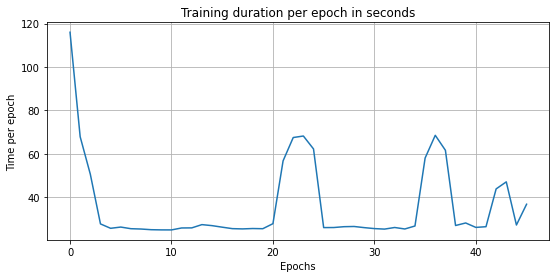

In [9]:
%%time
model_cv2 = createModel(class_num=11)
history_cv2 = model_cv2.fit(X_train, y_train_encoded, 
                               epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE,
                                   validation_data=(X_val, y_val_encoded),
                                       callbacks=[early_stopping, reduce_lr, time_callback])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-7)
time_callback = TimeHistory()

Epoch 1/50
591/591 [==============================] - 568s 961ms/step - loss: 1.3028 - accuracy: 0.5696 - val_loss: 0.7408 - val_accuracy: 0.7587
Epoch 2/50
591/591 [==============================] - 46s 78ms/step - loss: 0.9093 - accuracy: 0.7009 - val_loss: 0.6464 - val_accuracy: 0.7894
Epoch 3/50
591/591 [==============================] - 27s 46ms/step - loss: 0.8186 - accuracy: 0.7244 - val_loss: 0.5956 - val_accuracy: 0.8054
Epoch 4/50
591/591 [==============================] - 38s 65ms/step - loss: 0.7556 - accuracy: 0.7487 - val_loss: 0.5692 - val_accuracy: 0.8122
Epoch 5/50
591/591 [==============================] - 48s 81ms/step - loss: 0.7142 - accuracy: 0.7595 - val_loss: 0.5552 - val_accuracy: 0.8174
Epoch 6/50
591/591 [==============================] - 27s 45ms/step - loss: 0.6907 - accuracy: 0.7704 - val_loss: 0.5296 - val_accuracy: 0.8265
Epoch 7/50
591/591 [==============================] - 31s 53ms/step - loss: 0.6717 - accuracy: 0.7727 - val_loss: 0.5486 - val_accurac

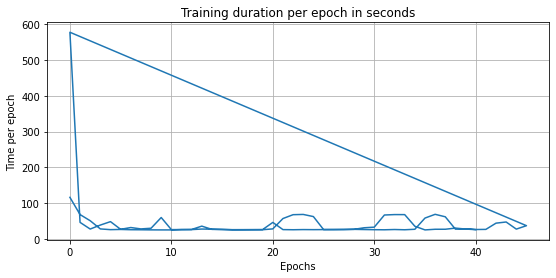

In [10]:
%%time
model_data_gen = createModel(class_num=10)
history_data_gen = model_data_gen.fit(training_dataset_flow, 
                                         epochs=TRAINING_EPOCHS, batch_size=BATCH_SIZE, 
                                            validation_data=(validation_dataset_flow),
                                                callbacks=[early_stopping, reduce_lr, time_callback], 
                                                    verbose=1)

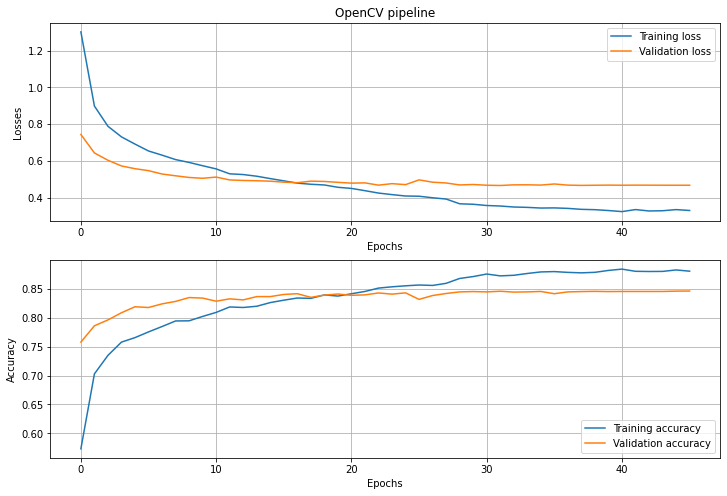

In [24]:
fig = plt.figure(figsize=(12, 8))
ax_1 = fig.add_subplot(211)
ax_1.set_title('OpenCV pipeline')
ax_1.set_xlabel('Epochs')
ax_1.set_ylabel('Losses')
ax_1.plot(history_cv2.history['loss'], label='Training loss')
ax_1.plot(history_cv2.history['val_loss'], label='Validation loss')
ax_1.legend(loc='best')
ax_1.grid(True)
ax_2 = fig.add_subplot(212)
ax_2.set_xlabel('Epochs')
ax_2.set_ylabel('Accuracy')
ax_2.plot(history_cv2.history['accuracy'], label='Training accuracy')
ax_2.plot(history_cv2.history['val_accuracy'], label='Validation accuracy')
ax_2.legend(loc='best')
ax_2.grid(True)

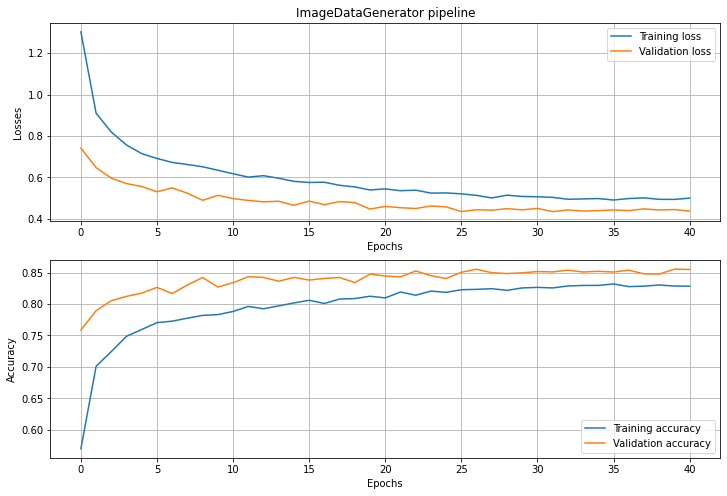

In [23]:
fig = plt.figure(figsize=(12, 8))
ax_1 = fig.add_subplot(211)
ax_1.set_title('ImageDataGenerator pipeline')
ax_1.set_xlabel('Epochs')
ax_1.set_ylabel('Losses')
ax_1.plot(history_data_gen.history['loss'], label='Training loss')
ax_1.plot(history_data_gen.history['val_loss'], label='Validation loss')
ax_1.legend(loc='best')
ax_1.grid(True)
ax_2 = fig.add_subplot(212)
ax_2.set_xlabel('Epochs')
ax_2.set_ylabel('Accuracy')
ax_2.plot(history_data_gen.history['accuracy'], label='Training accuracy')
ax_2.plot(history_data_gen.history['val_accuracy'], label='Validation accuracy')
ax_2.legend(loc='best')
ax_2.grid(True)

In [ ]:
model_cv2.save('ResNet50V2_opencv')

In [29]:
model_data_gen.save('ResNet50V2_imageDataGen')

INFO:tensorflow:Assets written to: ResNet50V2_imageDataGen\assets


In [30]:
tf.keras.models.save_model(model_cv2, 'ResNet50V2_opencv.h5')

In [31]:
tf.keras.models.save_model(model_data_gen, 'ResNet50V2_imageDataGen.h5')